<h1><center> AML Detection Challenge
    <br>
    <br> Bayes Solution

<h3>Imports

In [1]:
import tqdm
import pandas as pd                    
import numpy as np  
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

<h3> Load Data

In [2]:
#Point to file directory
directory = "D:\\Users\\dnicholson10\\Documents\\Projects\\LU Maths Challenge\\1. Data Generation\\"

#Load accounts data file
file = "20191111_Accounts.csv"
ac = pd.read_csv(directory+file)
print('Number of accounts: ', len(ac))

#Load transactions data file 
file = "20191111_Transactions.csv"
date = ['timestamp']
tx = pd.read_csv(directory+file, parse_dates=date)
print('Number of transactions: ', len(tx))
print('Number of labelled transactions: ', len(tx[tx.is_suspx!='Unknown']))

Number of accounts:  10000
Number of transactions:  515721
Number of labelled transactions:  257787


<h3>Plot amount densities

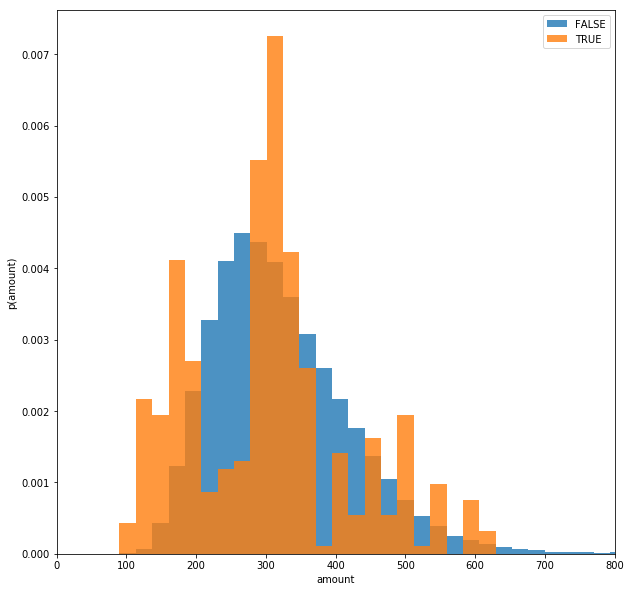

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
tx_1 = tx[tx['is_suspx']=='True']  
tx_0 = tx[tx['is_suspx']=='False']
_, bins, _ = plt.hist(tx_0['amount'], bins=100, density=True, alpha=0.8, label='FALSE')
_ = plt.hist(tx_1['amount'], bins=bins, alpha=0.8, density=True, label='TRUE')
plt.legend(loc='best')
plt.xlim([0,800])
plt.xlabel('amount'), plt.ylabel('p(amount)')
plt.show()

<h3>Kernel Density Estimation

(0, 800)

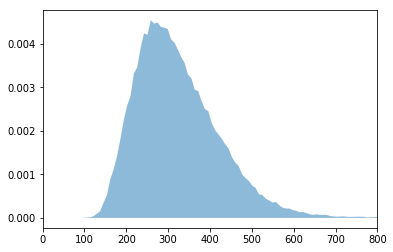

In [8]:
# extract amount vector
x = tx_0['amount'].values

# fit density to data
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:,None])

# score uniform test samples
x_d = np.linspace(0, 800, 100)
logprob = kde.score_samples(x_d[:,None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.xlim(0, 800)

<h3>Bayes Classification

In [10]:
def predict_proba(train, test):
    
    bandwidths = [1.0, 1.0]
    kernels = ['gaussian', 'gaussian']
    C = ['False', 'True']
    
    result = np.empty(shape=(2,len(test)))
    for i in range(2):

        temp = train[train['is_suspx']==C[i]]
        Xi = temp['amount'].values
        model = KernelDensity(bandwidth=bandwidths[i], kernel=kernels[i]).fit(Xi[:,None])
        
        #need to work with log probability because multiplication causes numerical underflow
        logprior = np.log(Xi.shape[0]/len(train))
        
        Xt = test['amount'].values
        logprob = np.array(model.score_samples(Xt[:,None])).T 
        prob = np.exp(logprior + logprob) # Bayes Theorem
        result[i,:] = prob
    return result / result.sum(0, keepdims=True)

#Extract what we need from Tx
temp = tx[tx['is_suspx']!='Unknown']
train = temp[['amount','is_suspx']]
temp = tx[tx['is_suspx']=='Unknown']
test = temp[['id','amount']]
#Predict probabilities
probs = predict_proba(train, test)

<h3>Create a submission file

In [14]:
test['P'] = probs[1,:]
test['alert_type'] = 'A1'
test2 = test.sort_values(by='P', ascending=False)
submit = test2.iloc[0:1000,:]
submit = submit[['id','P','alert_type']].set_index('id')
submit.to_csv('results.tsv', sep='\t')

d:\users\dnicholson10\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
d:\users\dnicholson10\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
